# Boosted Tree Regression

### Author(s): [Ben Dykstra](https://github.com/bfdykstra)
### Date:  July, 2017
### Tags: #Data-science, #machine-learning, #hot-prospects, #boosted-trees

***
###	TLDR:
The notebook goes through the process of optimizing a boosted tree using gridsearch.
***

### Motivation

We want to make the best model that we can. How do we know if the parameters we've chosen are the ones that yield the best results?

### Process

I iterate over the parameter space of the xgboost package using a gridsearch. This search chooses the parameters that yield the lowest error or whatever metric we are trying to minimize.





load all of data and define a couple of helper functions that help in visualizing how the model performs.

In [60]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cross_validation import KFold
import seaborn as sns
import json
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18.5, 10.5

predictors = ['golf_course', 'google_fiber',
       'verizon_fios', 'att_uverse', 'door_attendant', 'elevator',
       'utilities_included', 'vintage_building', 'smoke_free_community',
       'air_conditioning', 'all_dogs_allowed', 'cable_or_satellite',
       'cats_allowed', 'ceiling_fan', 'dishwasher', 'extra_storage',
       'large_dogs', 'laundry_facility', 'patio_or_balcony',
       'pets_allowed', 'pool', 'public_transportation',
       'small_dogs_allowed', 'view', 'walk_in_closets', 'hardwood_floor',
       'accepts_credit_card_payments', 'accepts_electronic_payments',
       'wireless_internet_access', 'broadband_internet_access',
       'business_center_onsite', 'club_house', 'controlled_access',
       'disability_access', 'fitness_center', 'garages', 'microwave',
       'washer_dryer_in_unit', 'luxury_amenities', 'furnished_available',
       'short_term_lease', 'covered_lot', 'fireplace', 'spa', 'playground',
       'tennis_court', 'washer_dryer_hookup', 'alarm_system',
       'hablamos_espanol', 'community_price',
              
        'search_count', 'mean_max_price', 'mean_min_price',
       'accepts_credit_card_payments_search',
       'accepts_electronic_payments_search', 'air_conditioning_search',
       'alarm_system_search', 'all_dogs_allowed_search',
       'broadband_internet_access_search', 'business_center_onsite_search',
       'cable_or_satellite_search', 'cats_allowed_search',
       'ceiling_fan_search', 'club_house_search',
       'controlled_access_search', 'covered_lot_search',
       'disability_access_search', 'dishwasher_search',
       'door_attendant_search', 'elevator_search', 'extra_storage_search',
       'fireplace_search', 'fitness_center_search',
       'furnished_available_search', 'garages_search',
       'hablamos_espanol_search', 'hardwood_floor_search',
       'large_dogs_search', 'laundry_facility_search',
       'luxury_amenities_search', 'microwave_search',
       'patio_or_balcony_search', 'pets_allowed_search',
       'playground_search', 'pool_search', 'public_transportation_search',
       'short_term_lease_search', 'small_dogs_allowed_search',
       'smoke_free_community_search', 'spa_search',
       'utilities_included_search', 'verizon_fios_search', 'view_search',
       'walk_in_closets_search', 'washer_dryer_hookup_search',
       'washer_dryer_in_unit_search', 'wireless_internet_access_search']

groups = ['community_price', 'in_FL', 'in_CA', 'Group1', 'Group2', 'Group3', 'Group4', 'Group5', 'Group6', 'Group7']
target = 'digital_leads'

data_path = '/Users/benjamin.dykstra/Documents/hot_prospects/data/combined_search.csv'

model_name = 'combined_search'

#dictionary of parameters that will be tuned and modified throughout the program
param_list = {'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 1000,
 'nthread': -1,
 'objective': 'reg:linear',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': True,
 'subsample': 0.8}

In [54]:
"""Computes the root mean squared error"""
def rmse(y_actual, y_predicted):
    
    RMSE = mean_squared_error(y_actual, y_predicted)**0.5
    return RMSE

rmse_scoring = make_scorer(rmse, greater_is_better= False)

In [3]:
def plot_resids(y_pred, resid):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    sns.regplot(y_pred, resid, ax=ax);

In [38]:
def modelfit(alg, dtrain, dtest, predictors, target = 'digital_leads', useTrainCV=True, cv_folds=5, 
             early_stopping_rounds=50, log_transform = True):
    if log_transform:
        #y_train = dtrain[dtrain[target]]
        y_train = np.log(dtrain[target])
        y_test = np.log(dtest[target])
    else:
        y_train = dtrain[target]
        y_test = dtest[target]
        
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label = y_train.values)
        
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round = alg.get_params()['n_estimators'], nfold = cv_folds,
            metrics=['rmse'], early_stopping_rounds = early_stopping_rounds, show_progress = False, seed = 27)
        print 'Stopped at round ', cvresult.shape[0]
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], y_train,eval_metric='rmse')
        
    #Predict training set:
    dtest_predictions = alg.predict(dtest[predictors])
    #print dtrain_predictions[:5]
    resid = dtest_predictions - y_test
    
    #print y_test.values
    #print dtest_predictions
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % rmse(y_test.values, dtest_predictions)
    print "R2 Score (Train): %f" % alg.score(dtrain[predictors], y_train)
    print "R2 Score (Test): %f" % alg.score(dtest[predictors], y_test)
    print "residual mean: ", resid.mean()
    print "residual standard error: ", resid.std()
    print "Mean Prediction: ", dtest_predictions.mean()
    print "Median Prediction: ", np.median(dtest_predictions)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances', figsize = (18.5, 10.5))
    plt.ylabel('Feature Importance Score')
    
    plot_resids(dtest_predictions, resid)
    
    fig, ax = plt.subplots()
    fig.set_size_inches = (18.5, 10.5)
    fig.title = 'Residuals'
    sns.distplot(resid, ax = ax);
    
    

In [5]:
def city_state_split(data, col):
    city_state = pd.DataFrame(data[col].str.split(',').tolist())
    city_state = city_state.rename(columns={0:'city',1:'state'})
    city_state['state'] = city_state['state'].str.strip()
    return pd.concat([data, city_state], axis=1)

In [6]:
def preprocess_data(path, test_size, split_up = True, mark_FL_and_CA = False, divide_by_count = False):
    df = pd.read_csv(path)
    
    new_df = df[df['digital_leads']!= 0]
    new_df = new_df[~new_df['digital_leads'].isnull()]
        
    if split_up:
        new_df = city_state_split(new_df, 'city_state')
    


    #split into training and testing
    train, test = cross_validation.train_test_split(new_df, test_size = test_size, random_state = 27)
    
    return train, test, new_df

This is the function that we will use to tune the model. It takes in an estimator and the parameters to be optimized and performs the gridsearch over those parameters. 

In [52]:
def tune_w_GS(testing_params, estimator, data, predictors, target, n_folds = 5, log_transform = True):
    
    gsearch = GridSearchCV(estimator, param_grid = testing_params, n_jobs = 5, iid = False, 
                          cv= KFold(data.shape[0], n_folds= n_folds, random_state = 27), scoring = rmse_scoring)
    
    if log_transform:
        gsearch.fit(data[predictors], np.log(data[target]))
    else:
        gsearch.fit(data[predictors], data[target])
        
    gsearch.grid_scores_ 
    print gsearch.best_params_
    print gsearch.best_score_
    
    return gsearch

## Split into training and test sets

66, 33 split

In [8]:
train_cities_raw, test_cities_raw, cities_raw = preprocess_data(data_path, test_size = 0.33, divide_by_count= False)


(3205, 101)
(3199, 101)


See how the leads are distributed in the dataset

In [9]:
print cities_raw['digital_leads'].describe()

count     3199.000000
mean       517.984683
std       1518.365047
min          1.000000
25%         41.000000
50%        115.000000
75%        371.000000
max      29492.000000
Name: digital_leads, dtype: float64


In [10]:
cities_raw = cities_raw[~cities_raw['digital_leads'].isnull()]

In [11]:
test_cities_raw = test_cities_raw[~test_cities_raw['digital_leads'].isnull()]
train_cities_raw = train_cities_raw[~train_cities_raw['digital_leads'].isnull()]

put zeroes in to any place that's na

In [12]:
train_cities_raw, test_cities_raw, cities_raw = train_cities_raw.fillna(value = 0), test_cities_raw.fillna(value = 0), cities_raw.fillna(value = 0)

In [13]:
print train_cities_raw.shape
print test_cities_raw.shape
print cities_raw.shape

(2142, 103)
(1057, 103)
(3199, 103)


# Initial Model, nothing tuned

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1000, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 27, 'min_child_weight': 1, 'objective': 'reg:linear', 'max_depth': 5, 'gamma': 0}


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 74


Stopped at round  75
[ 7.23201033  3.76120012  4.63472899 ...,  6.86380339  3.98898405
  2.89037176]
[ 6.19158554  4.24901152  3.82001138 ...,  6.43445063  5.1482358
  3.93324661]

Model Report
Accuracy : 0.7895
R2 Score (Train): 0.915887
R2 Score (Test): 0.772573
residual mean:  0.0346466678784
residual standard error:  0.789091938314
Mean Prediction:  4.86717
Median Prediction:  4.66933


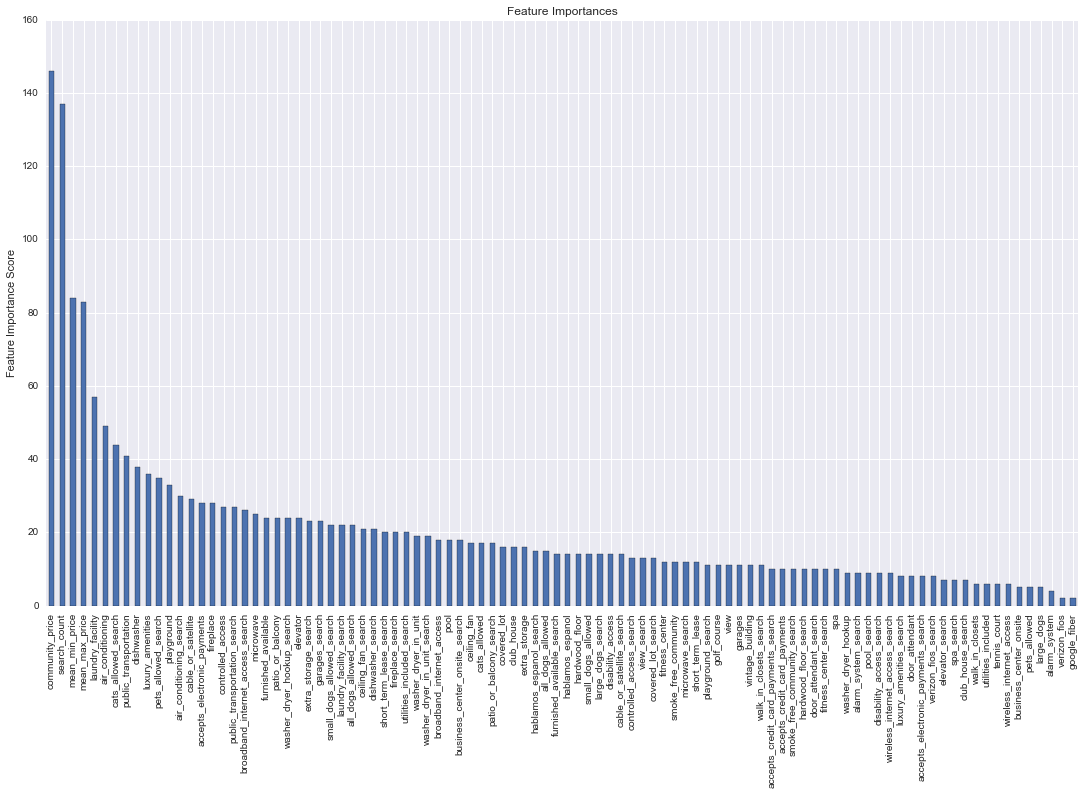

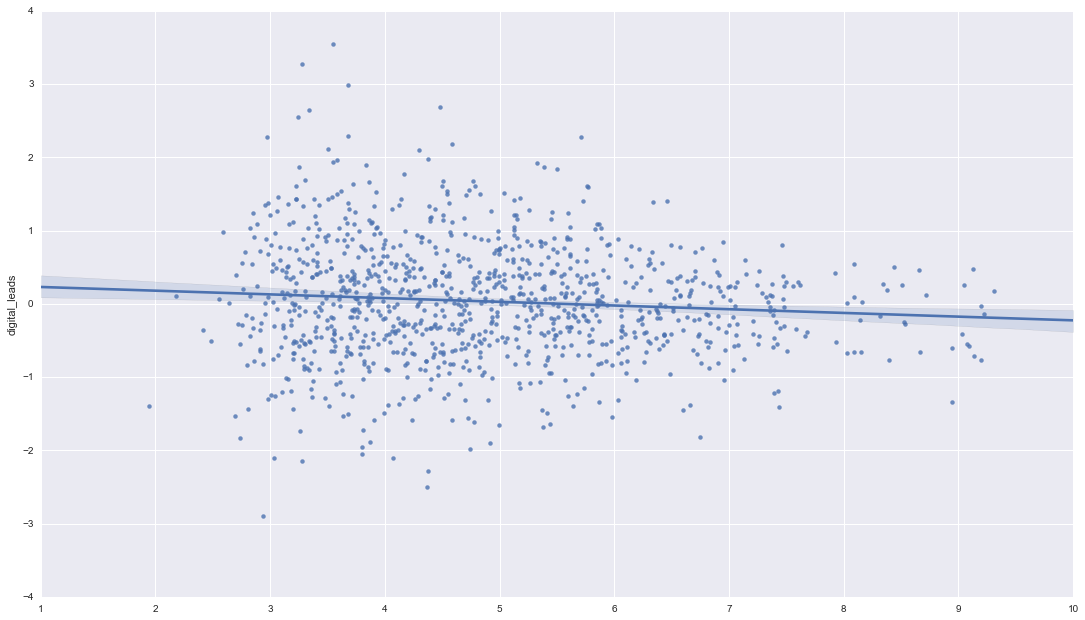

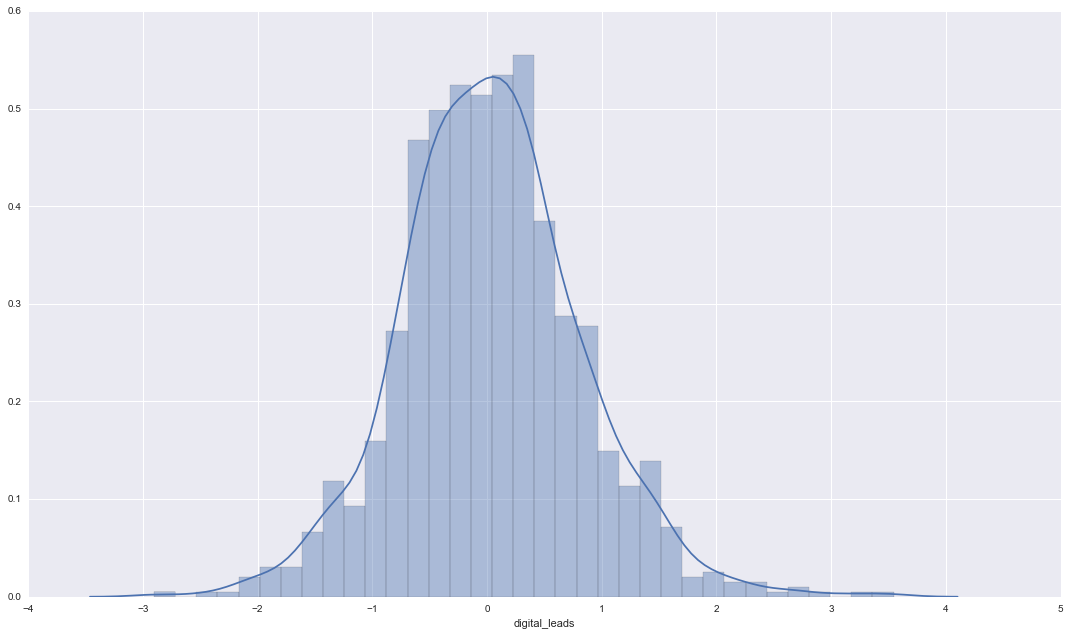

In [14]:
print param_list
xgb1 = XGBRegressor(**param_list)
modelfit(xgb1, train_cities_raw, test_cities_raw, predictors, log_transform=True)


# Tune max_depth and min_child_weight

Tuning the maximum depth of the trees helps to control for overfitting. The minimum child weight is a parameter that controls at what point a node should split in two or not.

In [26]:

#try 3 different max_depths, and 3 different child weights
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = tune_w_GS(param_test1, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')

# gsearch1 = GridSearchCV(estimator =XGBRegressor(**param_list), param_grid = param_test1, n_jobs=5,iid=False, 
#                         cv= KFold(cities_raw.shape[0], n_folds= 7, random_state = 27))

# gsearch1.fit(cities_raw[predictors],np.log(cities_raw[target]))
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [27]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -687.05455, std: 197.09646, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -659.94927, std: 188.06482, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -688.78194, std: 201.36481, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -752.04464, std: 205.50265, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -715.50972, std: 231.12501, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -731.17631, std: 196.02649, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -759.21863, std: 186.62624, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -717.91769, std: 196.89196, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -715.88781, std: 191.57601, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -747.15915, std: 208.94565, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -719.21024, std: 200.66648, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -713.12280, std: 188.70338, params: {'max_depth': 9, 'min

tuning the min_child_weight so that it's lower, tune max depth so that it's higher

In [29]:
#try 4 different max_depths, and 4 different child weights
param_test1b = {
    'max_depth':range(2,5),
    'min_child_weight': range(1,5)
    }


gsearch1b = tune_w_GS(param_test1b, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')
# gsearch1b = GridSearchCV(estimator =XGBRegressor(**param_list),param_grid = param_test1b, n_jobs=5,iid=False, 
#                          cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27))


# gsearch1b = GridSearchCV(estimator =XGBRegressor(**param_list),param_grid = param_test1b, n_jobs=5,iid=False, 
#                           cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27))


# gsearch1b.fit(cities_raw[predictors],cities_raw[target])


In [31]:
gsearch1b.grid_scores_, gsearch1b.best_params_, gsearch1b.best_score_

([mean: -677.88424, std: 199.90805, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -673.42687, std: 185.90313, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: -681.85635, std: 181.11233, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -678.55773, std: 158.73816, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -687.05455, std: 197.09646, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -687.75468, std: 196.43296, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -659.94927, std: 188.06482, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -673.81513, std: 182.47260, params: {'max_depth': 3, 'min_child_weight': 4},
  mean: -713.41245, std: 205.65748, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -752.81065, std: 244.24643, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -702.54269, std: 235.39884, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -673.18432, std: 175.22539, params: {'max_depth': 4, 'min

Okay so, max_depth REALLY affects the residual spreads. The lower the depth, the worse it does predicting lower values, and the higher the depth it does much better predicting the lower values. Observe the difference between max depth of 3 (as specified by the grid search which is optimizing R2), and max depth of 9

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1000, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 27, 'min_child_weight': 3, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0}


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 145


Stopped at round  146

Model Report
Accuracy : 1014
R2 Score (Train): 0.862043
R2 Score (Test): 0.767377
residual mean:  0.0426253150644
residual standard error:  0.797687097057
Mean Prediction:  4.87515
Median Prediction:  4.68214


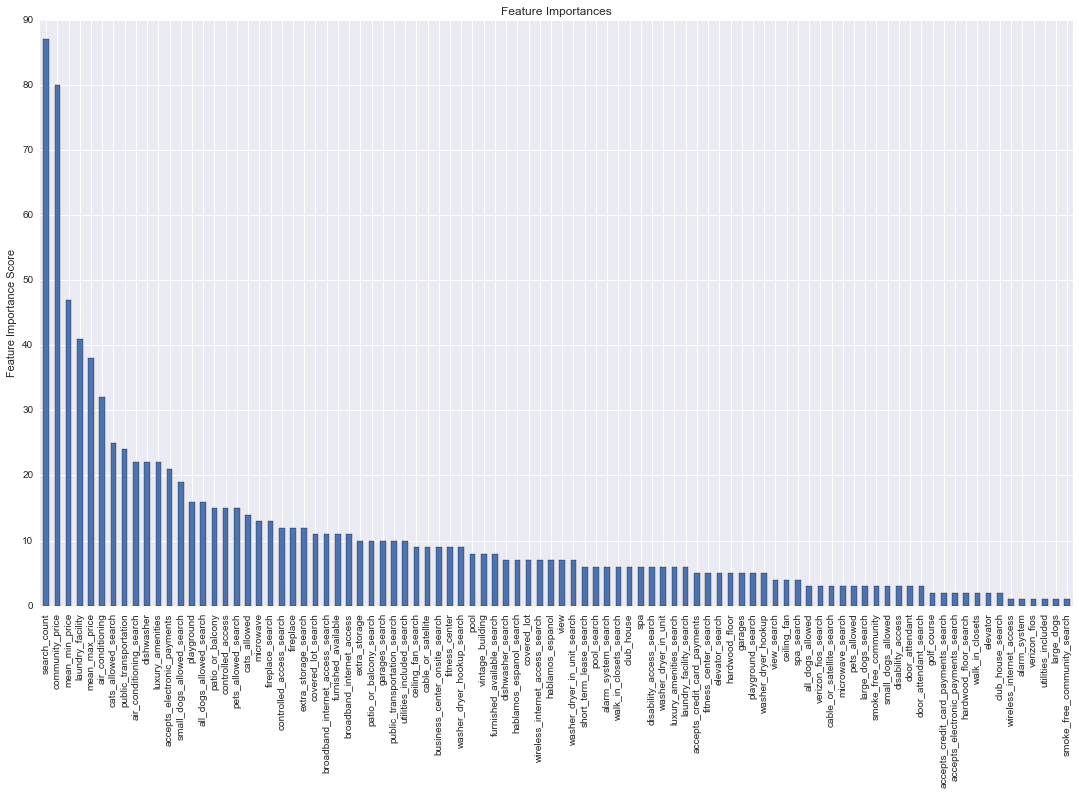

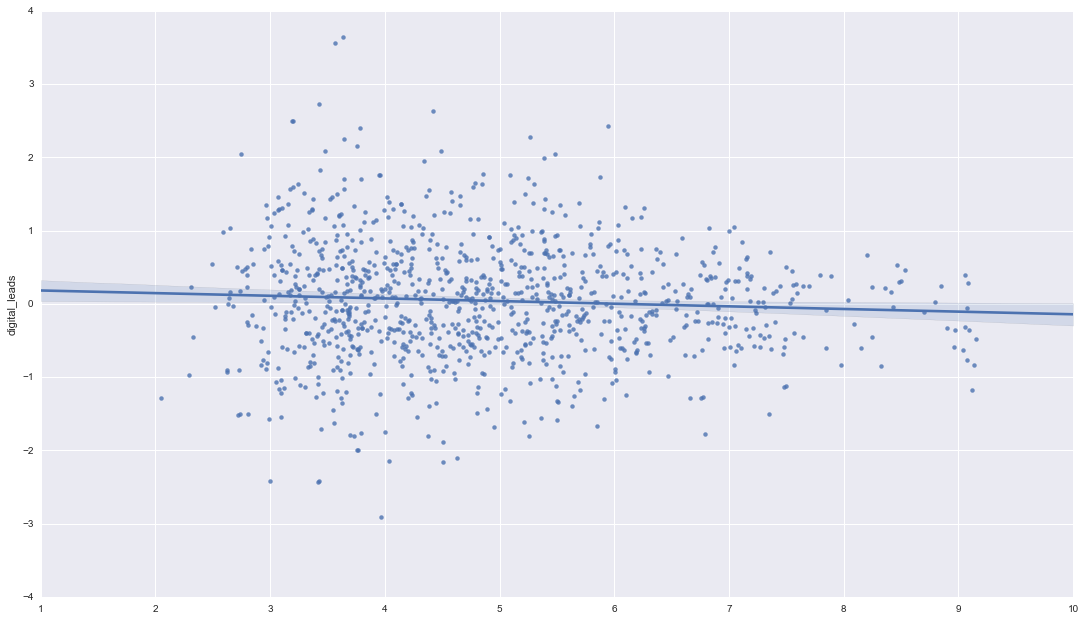

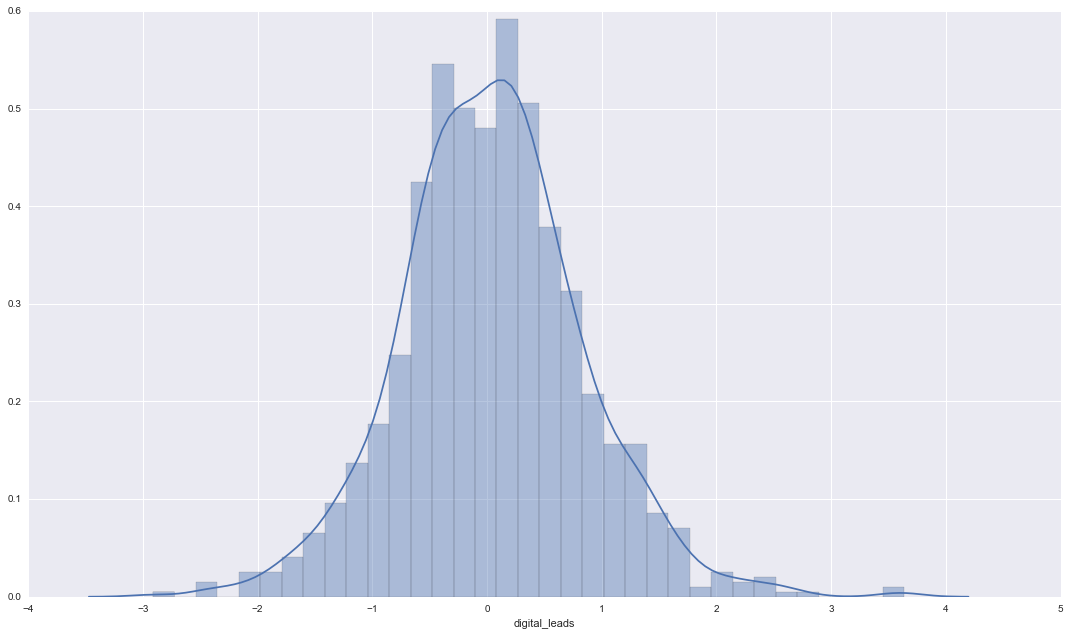

In [39]:
#depth of 8
param_list = gsearch1b.best_estimator_.get_params()

print param_list
xgb2 = XGBRegressor(**param_list)
modelfit(xgb2, train_cities_raw, test_cities_raw, predictors)

## Tune gamma

gamma is a regularization parameter

In [40]:
param_test2 = {
 'gamma':[i/100.0 for i in range(0,30, 5)]
}

gsearch2 = tune_w_GS(param_test2, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')
# gsearch2 = GridSearchCV(estimator =XGBRegressor(**param_list),param_grid = param_test2, n_jobs=5,iid=False, 
#                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

# gsearch2.fit(cities_raw[groups],cities_raw[target])
# gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

[mean: -659.94927, std: 188.06482, params: {'gamma': 0.0}, mean: -679.05997, std: 221.18889, params: {'gamma': 0.05}, mean: -663.96792, std: 192.56665, params: {'gamma': 0.1}, mean: -680.44197, std: 208.47733, params: {'gamma': 0.15}, mean: -696.92643, std: 201.83117, params: {'gamma': 0.2}, mean: -703.56403, std: 216.87713, params: {'gamma': 0.25}] {'gamma': 0.0} -659.949272228


In [ ]:
param_test2b = {
 'gamma':[i/100.0 for i in range(25,45, 5)]
}

gsearch2b = GridSearchCV(estimator =XGBRegressor(**param_list), param_grid = param_test2b, n_jobs=5,iid=False, 
                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

gsearch2b.fit(cities_raw[groups],cities_raw[target])
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

In [41]:
param_list = gsearch2.best_estimator_.get_params()
print param_list

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1000, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 27, 'min_child_weight': 3, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}


Check the residual spread again to make sure we're not underfitting

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 145


Stopped at round  146

Model Report
Accuracy : 1014
R2 Score (Train): 0.862043
R2 Score (Test): 0.767377
residual mean:  0.0426253150644
residual standard error:  0.797687097057
Mean Prediction:  4.87515
Median Prediction:  4.68214


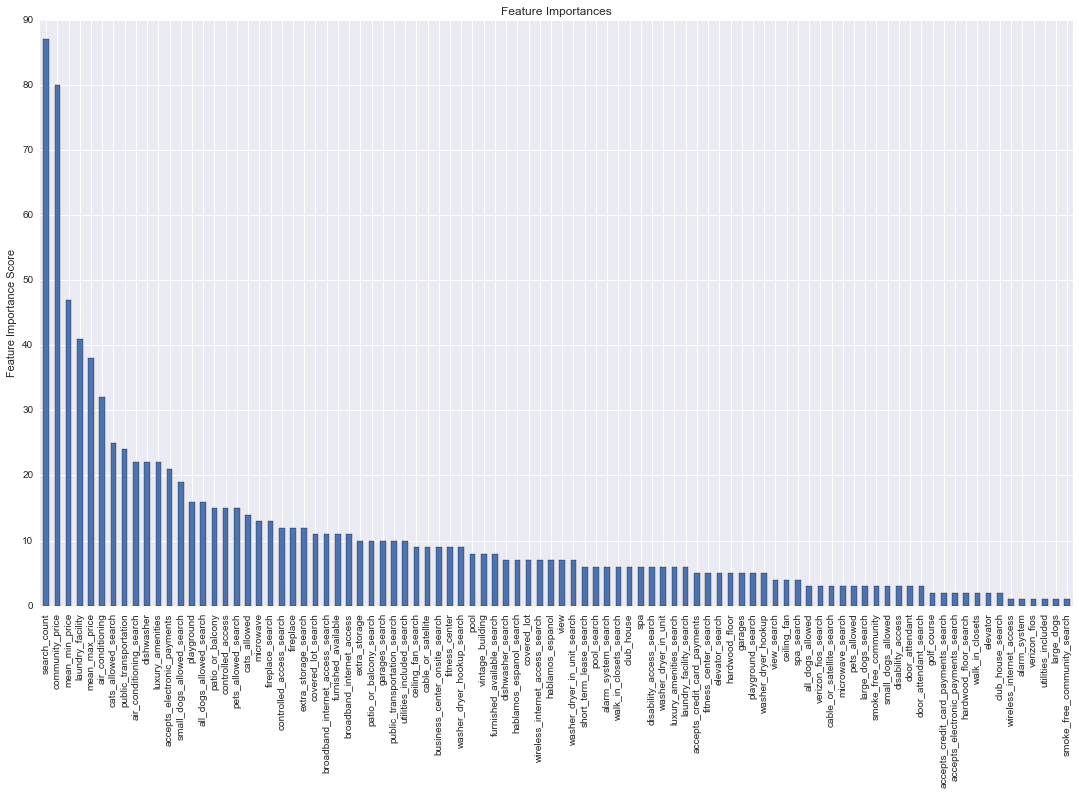

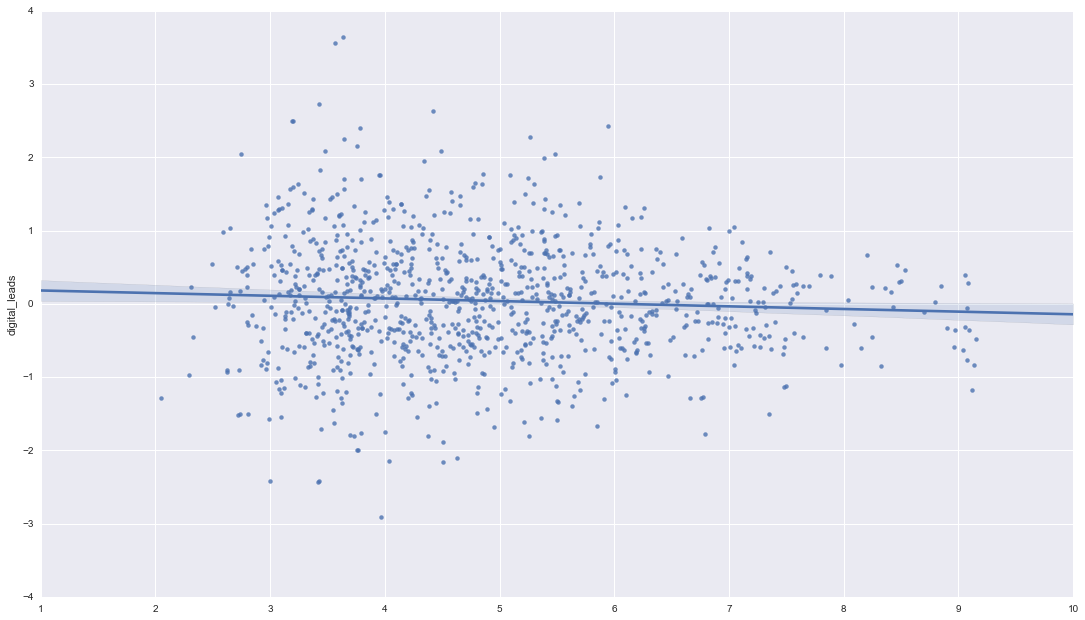

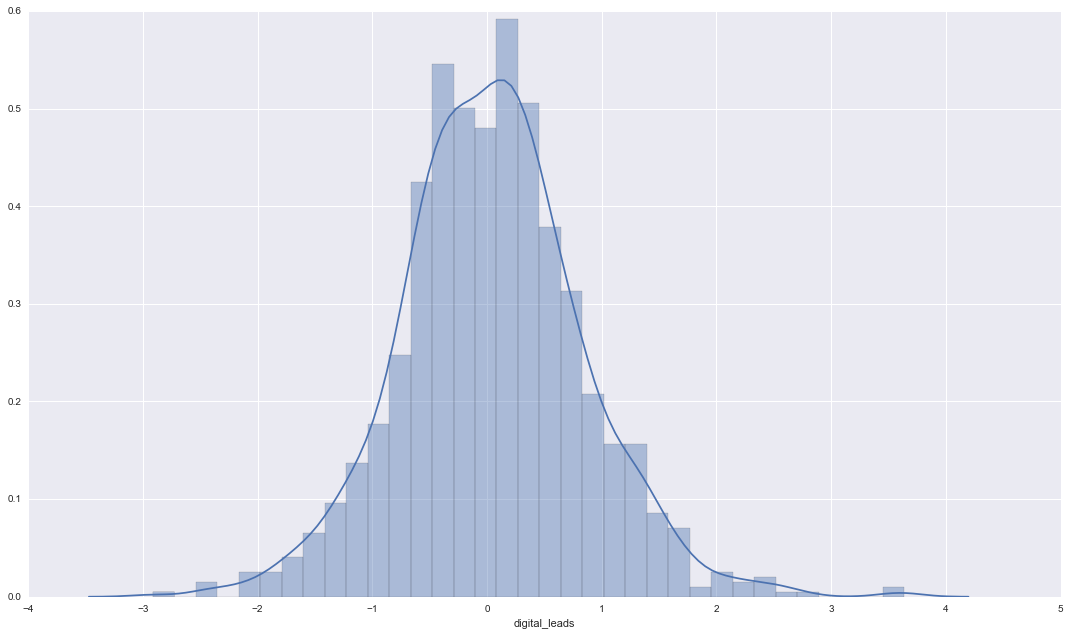

In [43]:
xgb3 = XGBRegressor(**param_list)
modelfit(xgb3, train_cities_raw, test_cities_raw, predictors)

Residual spread still looks good, we continue

## Tune subsample and colsample_bytree

Tunes how many of the rows and columns to sample at each iteration

In [44]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch3 = tune_w_GS(param_test3, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')
# gsearch3 = GridSearchCV(estimator = XGBRegressor(**param_list), param_grid = param_test3, n_jobs=5,iid=False, 
#                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

# gsearch3.fit(cities_raw[groups],cities_raw[target])
# gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

[mean: -676.88740, std: 150.53208, params: {'subsample': 0.6, 'colsample_bytree': 0.6}, mean: -690.79121, std: 227.61214, params: {'subsample': 0.7, 'colsample_bytree': 0.6}, mean: -695.79828, std: 182.18182, params: {'subsample': 0.8, 'colsample_bytree': 0.6}, mean: -679.63744, std: 193.42406, params: {'subsample': 0.9, 'colsample_bytree': 0.6}, mean: -698.19027, std: 185.32717, params: {'subsample': 0.6, 'colsample_bytree': 0.7}, mean: -709.77121, std: 197.76786, params: {'subsample': 0.7, 'colsample_bytree': 0.7}, mean: -683.05725, std: 188.36176, params: {'subsample': 0.8, 'colsample_bytree': 0.7}, mean: -697.02227, std: 180.80160, params: {'subsample': 0.9, 'colsample_bytree': 0.7}, mean: -716.20466, std: 210.40962, params: {'subsample': 0.6, 'colsample_bytree': 0.8}, mean: -682.02079, std: 178.43531, params: {'subsample': 0.7, 'colsample_bytree': 0.8}, mean: -659.94927, std: 188.06482, params: {'subsample': 0.8, 'colsample_bytree': 0.8}, mean: -705.86607, std: 181.91258, params: 

Drilling down farther into .05 intervals for subsample and colsample

In [ ]:
param_test4 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

gsearch4 = GridSearchCV(estimator = XGBRegressor(**param_list), param_grid = param_test4, n_jobs=5,iid=False, 
                        cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

gsearch4.fit(cities_raw[predictors],cities_raw[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

In [45]:
param_list = gsearch3.best_estimator_.get_params()

### Check the residual plot and how well it's fitting

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1000, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 27, 'min_child_weight': 3, 'objective': 'reg:linear', 'max_depth': 3, 'gamma': 0.0}


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 145


Stopped at round  146

Model Report
Accuracy : 1014
R2 Score (Train): 0.862043
R2 Score (Test): 0.767377
residual mean:  0.0426253150644
residual standard error:  0.797687097057
Mean Prediction:  4.87515
Median Prediction:  4.68214


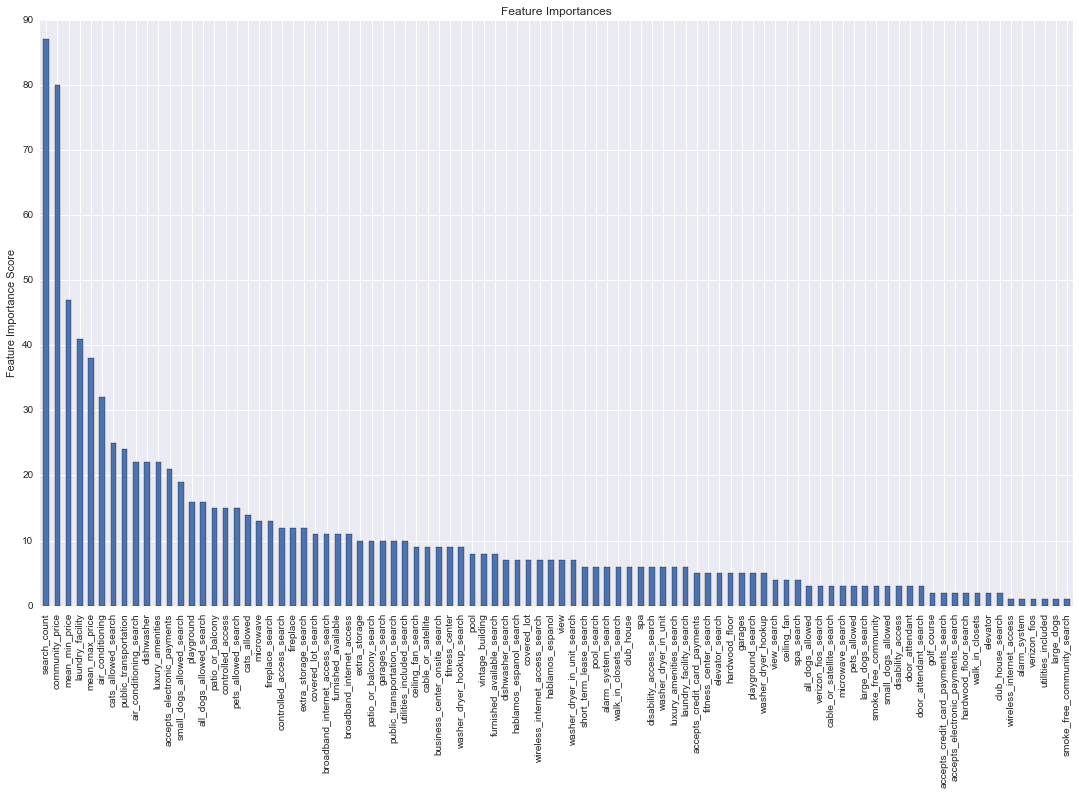

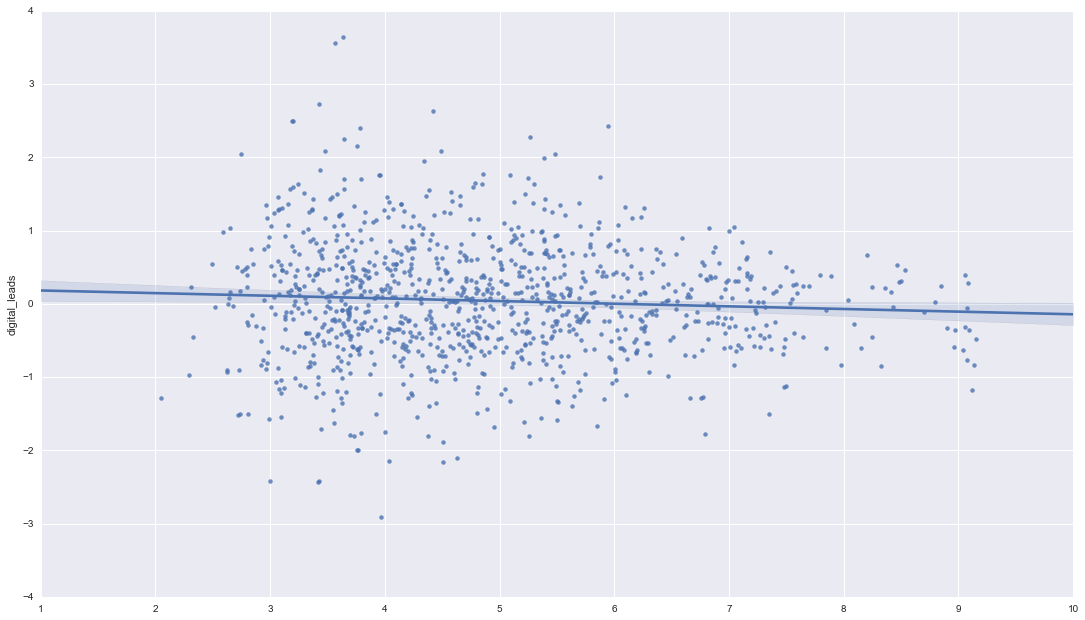

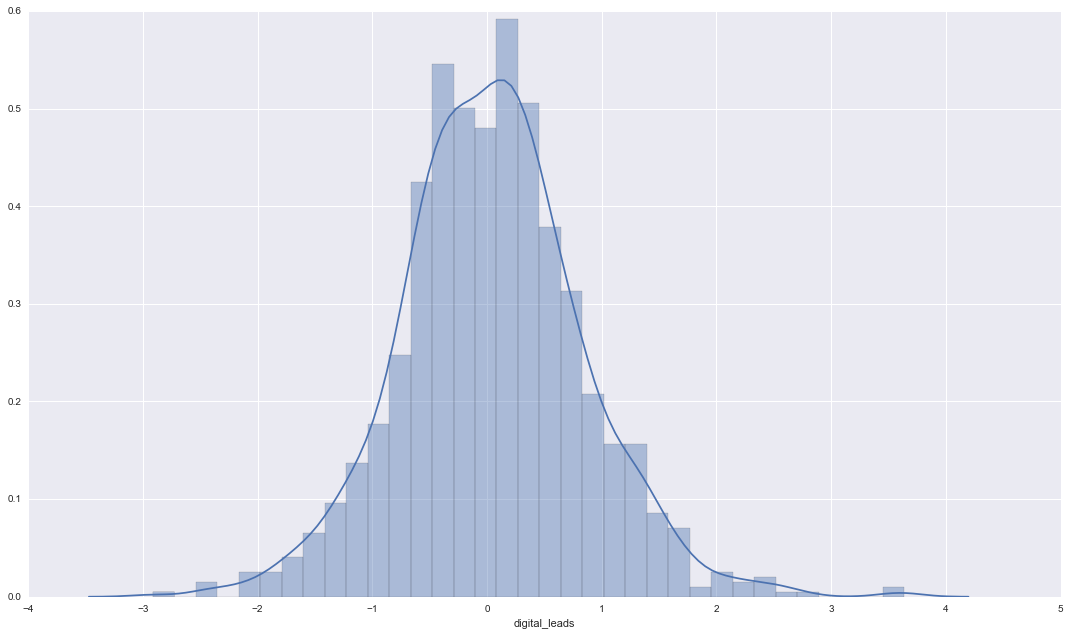

In [46]:
print param_list
xgb4 = XGBRegressor(**param_list)
modelfit(xgb4, train_cities_raw, test_cities_raw,predictors)

## Tune reg_alpha now ( L1 regularization term on weights)

In [49]:
param_test5 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 5, 10]
}

gsearch5 = tune_w_GS(param_test5, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')
# gsearch5 = GridSearchCV(estimator = XGBRegressor(**param_list),param_grid = param_test5, n_jobs=5,iid=False, 
#                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

# gsearch5.fit(cities_raw[predictors],cities_raw[target])
# gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

[mean: -659.94927, std: 188.06482, params: {'reg_alpha': 0}, mean: -659.95026, std: 188.06476, params: {'reg_alpha': 1e-05}, mean: -700.80024, std: 219.51859, params: {'reg_alpha': 0.01}, mean: -680.30807, std: 211.14989, params: {'reg_alpha': 0.1}, mean: -698.29474, std: 227.48081, params: {'reg_alpha': 1}, mean: -748.87878, std: 241.26583, params: {'reg_alpha': 5}, mean: -794.94421, std: 265.12658, params: {'reg_alpha': 10}]
{'reg_alpha': 0}
-659.949272228


In [ ]:
param_test5b = {
 'reg_alpha':[.005, .01, .015, .02, .025]
}

gsearch5b = GridSearchCV(estimator = XGBRegressor(**param_list),param_grid = param_test5b, n_jobs=5,iid=False, 
                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

gsearch5b.fit(cities_raw[groups],cities_raw[target])
gsearch5b.grid_scores_, gsearch5b.best_params_, gsearch5b.best_score_

In [50]:
param_list = gsearch5.best_estimator_.get_params()

In [ ]:
print param_list
xgb5 = XGBRegressor(**param_list)
modelfit(xgb5, train_cities_raw, test_cities_raw, groups)

Tune L2 penalization term now.

In [ ]:
param_test6 = {
 'reg_lambda':[.5, 1, 1.5, 2]
}

gsearch6 = GridSearchCV(estimator = XGBRegressor(**param_list), param_grid = param_test6, n_jobs=5,iid=False, 
                        cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

gsearch6.fit(cities_raw[groups],cities_raw[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

In [ ]:
param_test6b = {
 'reg_lambda':[.75, 1, 1.25]
}

gsearch6b = GridSearchCV(estimator = XGBRegressor(**param_list), param_grid = param_test6b, n_jobs=5,iid=False, 
                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

gsearch6b.fit(cities_raw[groups],cities_raw[target])
gsearch6b.grid_scores_, gsearch6b.best_params_, gsearch6b.best_score_

set parameter list again

In [ ]:
param_list = gsearch6b.best_estimator_.get_params()
print param_list

In [ ]:

xgb6 = XGBRegressor(**param_list)
modelfit(xgb6, train_cities_raw, test_cities_raw, groups)

Now we play with the learning rate and the number of estimators

In [51]:
param_test7 = {
    'learning_rate':[i/10.0 for i in range(1,8,2)],
    'n_estimators': [i for i in range(1000,6000, 1000)]
}

gsearch7 = tune_w_GS(param_test7, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')
# gsearch7 = GridSearchCV(estimator = XGBRegressor(**param_list), param_grid = param_test7, n_jobs=5,iid=False, 
#                         cv= KFold(cities_raw.shape[0], n_folds= 5, random_state = 27), scoring = rmse_scoring)

# gsearch7.fit(cities_raw[groups],cities_raw[target])
# gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

[mean: -659.94927, std: 188.06482, params: {'n_estimators': 1000, 'learning_rate': 0.1}, mean: -671.30473, std: 206.72262, params: {'n_estimators': 2000, 'learning_rate': 0.1}, mean: -674.49410, std: 211.63362, params: {'n_estimators': 3000, 'learning_rate': 0.1}, mean: -673.36068, std: 212.76205, params: {'n_estimators': 4000, 'learning_rate': 0.1}, mean: -671.94572, std: 211.37550, params: {'n_estimators': 5000, 'learning_rate': 0.1}, mean: -761.96425, std: 195.33446, params: {'n_estimators': 1000, 'learning_rate': 0.3}, mean: -759.38701, std: 198.32484, params: {'n_estimators': 2000, 'learning_rate': 0.3}, mean: -758.98179, std: 197.40480, params: {'n_estimators': 3000, 'learning_rate': 0.3}, mean: -759.10581, std: 197.54634, params: {'n_estimators': 4000, 'learning_rate': 0.3}, mean: -759.05114, std: 197.47222, params: {'n_estimators': 5000, 'learning_rate': 0.3}, mean: -914.68394, std: 286.65764, params: {'n_estimators': 1000, 'learning_rate': 0.5}, mean: -912.75020, std: 287.8650

In [56]:
param_test7b = {
    'learning_rate':[.01, .05, .1, .15, .2],
    'n_estimators': [i for i in range(500,2000, 500)]
}

gsearch7b = tune_w_GS(param_test7b, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')

# gsearch7b.fit(cities_raw[groups],cities_raw[target])
gsearch7b.grid_scores_, gsearch7b.best_params_, gsearch7b.best_score_

{'n_estimators': 1500, 'learning_rate': 0.01}
-0.787359766475


([mean: -0.81505, std: 0.02321, params: {'n_estimators': 500, 'learning_rate': 0.01},
  mean: -0.79279, std: 0.01996, params: {'n_estimators': 1000, 'learning_rate': 0.01},
  mean: -0.78736, std: 0.01917, params: {'n_estimators': 1500, 'learning_rate': 0.01},
  mean: -0.78757, std: 0.02050, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: -0.79055, std: 0.02114, params: {'n_estimators': 1000, 'learning_rate': 0.05},
  mean: -0.79598, std: 0.02115, params: {'n_estimators': 1500, 'learning_rate': 0.05},
  mean: -0.79949, std: 0.02393, params: {'n_estimators': 500, 'learning_rate': 0.1},
  mean: -0.81094, std: 0.02725, params: {'n_estimators': 1000, 'learning_rate': 0.1},
  mean: -0.81892, std: 0.02791, params: {'n_estimators': 1500, 'learning_rate': 0.1},
  mean: -0.81577, std: 0.01804, params: {'n_estimators': 500, 'learning_rate': 0.15},
  mean: -0.82921, std: 0.02324, params: {'n_estimators': 1000, 'learning_rate': 0.15},
  mean: -0.83428, std: 0.02233, params: {'n_estima

In [57]:
param_test7c = {
    'learning_rate':[.005, .01, .015, .02],
    'n_estimators': [i for i in range(1000,1750, 250)]
}

gsearch7c = tune_w_GS(param_test7c, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')

#gsearch7c.fit(cities_raw[groups],cities_raw[target])
gsearch7c.grid_scores_, gsearch7c.best_params_, gsearch7c.best_score_

{'n_estimators': 1250, 'learning_rate': 0.02}
-0.784005593993


([mean: -0.81465, std: 0.02493, params: {'n_estimators': 1000, 'learning_rate': 0.005},
  mean: -0.80409, std: 0.02343, params: {'n_estimators': 1250, 'learning_rate': 0.005},
  mean: -0.79820, std: 0.02274, params: {'n_estimators': 1500, 'learning_rate': 0.005},
  mean: -0.79279, std: 0.01996, params: {'n_estimators': 1000, 'learning_rate': 0.01},
  mean: -0.78911, std: 0.01949, params: {'n_estimators': 1250, 'learning_rate': 0.01},
  mean: -0.78736, std: 0.01917, params: {'n_estimators': 1500, 'learning_rate': 0.01},
  mean: -0.78769, std: 0.02100, params: {'n_estimators': 1000, 'learning_rate': 0.015},
  mean: -0.78670, std: 0.02088, params: {'n_estimators': 1250, 'learning_rate': 0.015},
  mean: -0.78617, std: 0.02093, params: {'n_estimators': 1500, 'learning_rate': 0.015},
  mean: -0.78473, std: 0.02059, params: {'n_estimators': 1000, 'learning_rate': 0.02},
  mean: -0.78401, std: 0.02131, params: {'n_estimators': 1250, 'learning_rate': 0.02},
  mean: -0.78464, std: 0.02177, param

In [62]:
param_list = gsearch7c.best_estimator_.get_params()

### Tuning the learning rate and the number of estimators had the biggest impact on performance yet

The training R2 is .95 and the test R2 is .77, both large improvement over previous cases. Remember, our initial model started at R2 Score (Train): 0.915887 and R2 Score (Test): 0.772573.

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': None, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1250, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 27, 'min_child_weight': 1, 'objective': 'reg:linear', 'max_depth': 5, 'gamma': 0.0}


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 649


Stopped at round  650

Model Report
Accuracy : 0.7842
R2 Score (Train): 0.956438
R2 Score (Test): 0.775623
residual mean:  0.0274490527773
residual standard error:  0.784058095004
Mean Prediction:  4.85998
Median Prediction:  4.68743


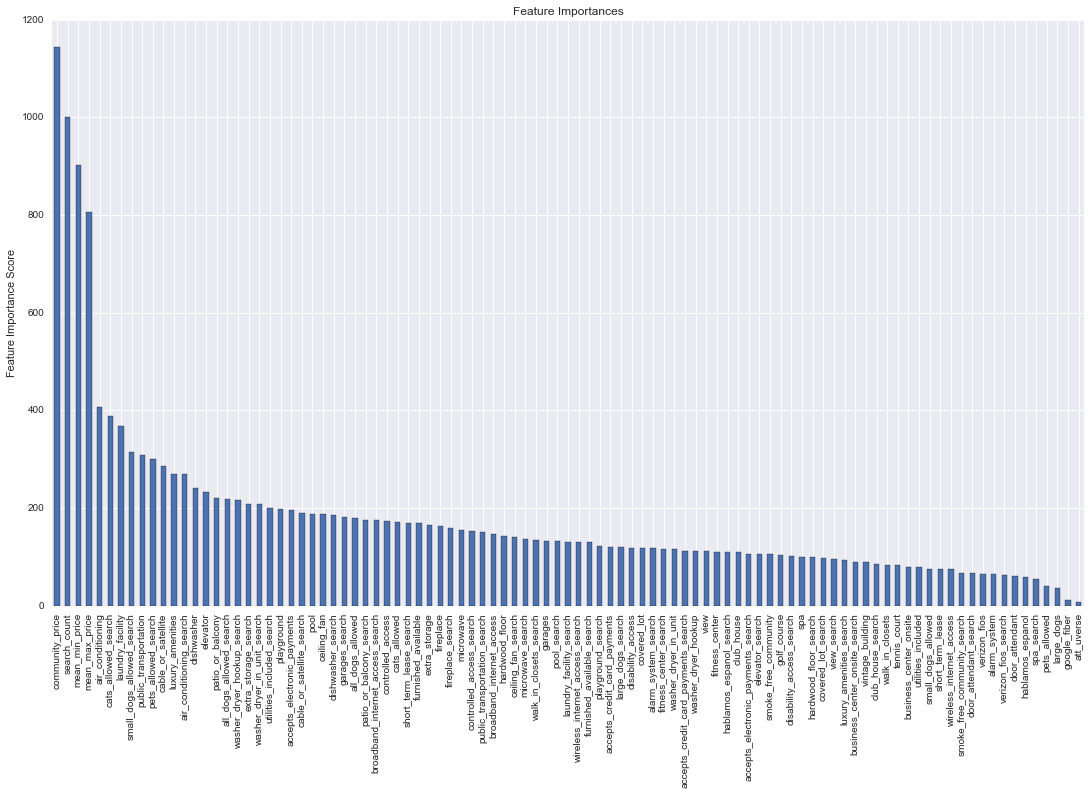

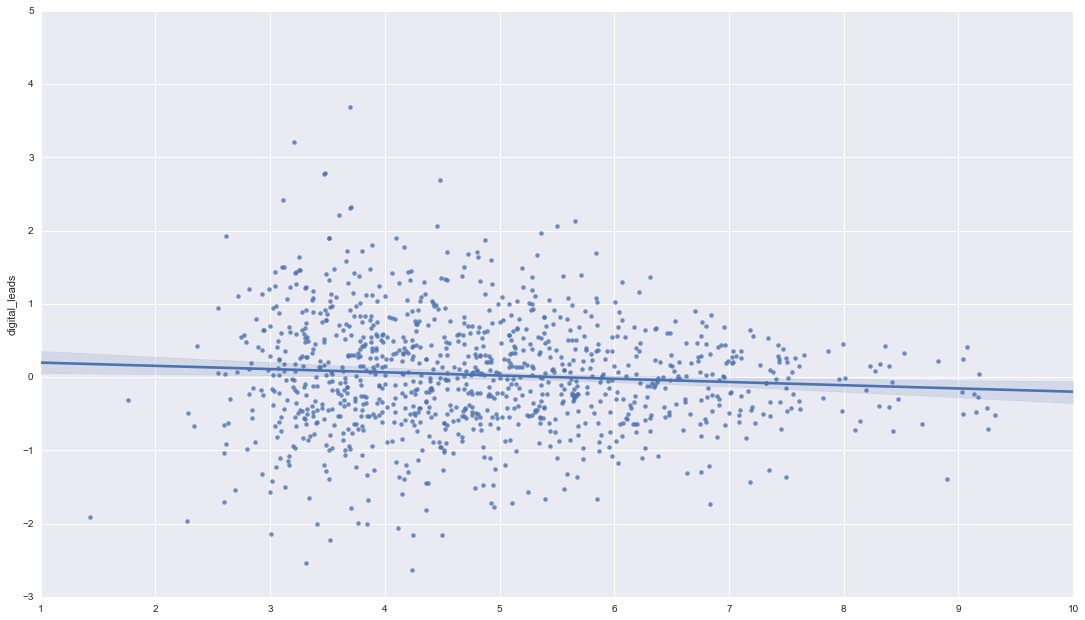

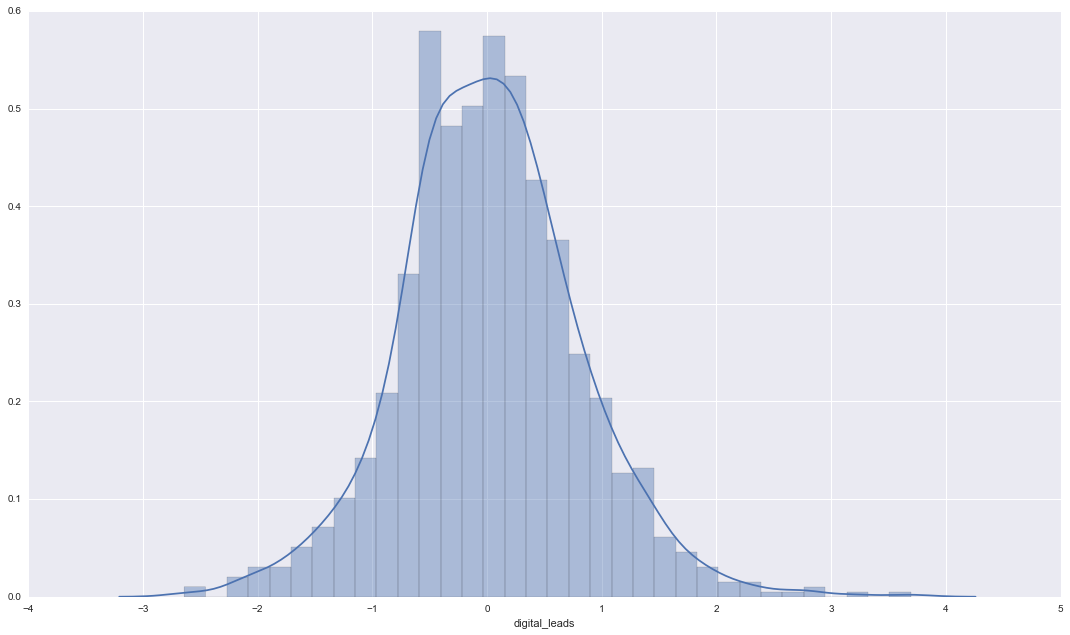

In [65]:
param_list['max_depth'] = 5
param_list['min_child_weight'] = 1
print param_list

xgb6 = XGBRegressor(**param_list)
modelfit(xgb6, train_cities_raw, test_cities_raw, predictors)

{'reg_alpha': 0, 'colsample_bytree': 0.8, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 1000, 'subsample': 0.8, 'reg_lambda': 1, 'seed': 27, 'min_child_weight': 1, 'objective': 'reg:linear', 'max_depth': 5, 'gamma': 0}


Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 74


Stopped at round  75

Model Report
Accuracy : 0.7895
R2 Score (Train): 0.915887
R2 Score (Test): 0.772573
residual mean:  0.0346466678784
residual standard error:  0.789091938314
Mean Prediction:  4.86717
Median Prediction:  4.66933


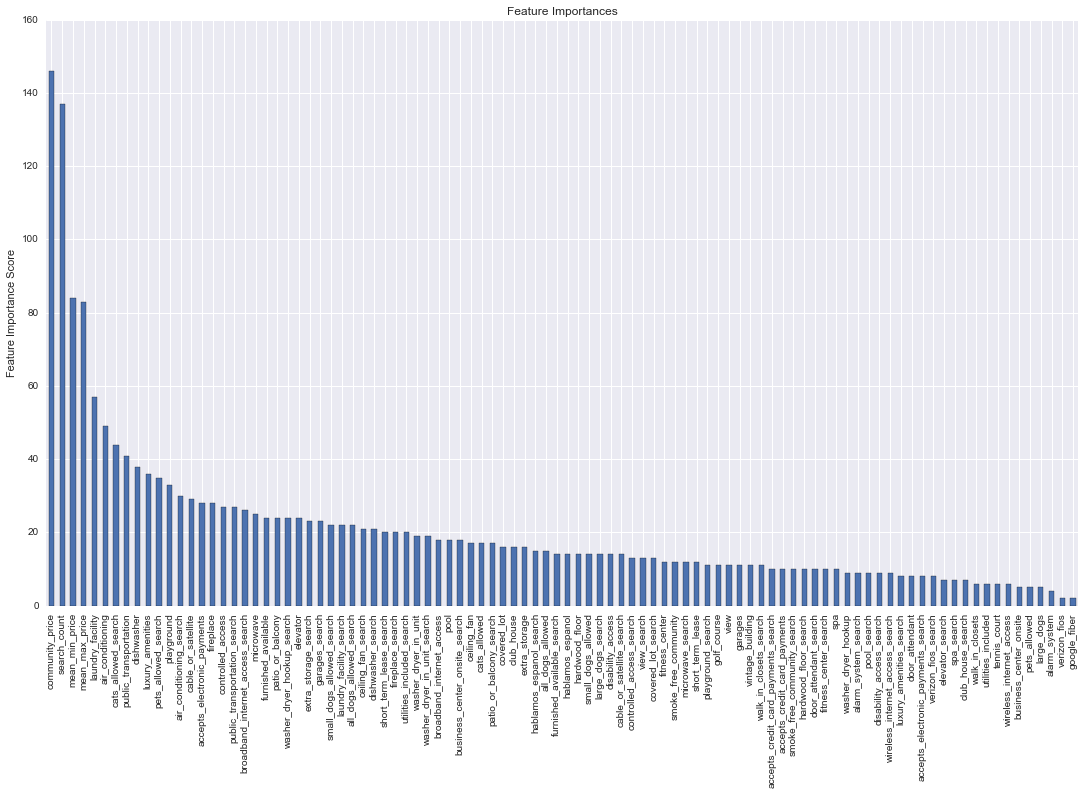

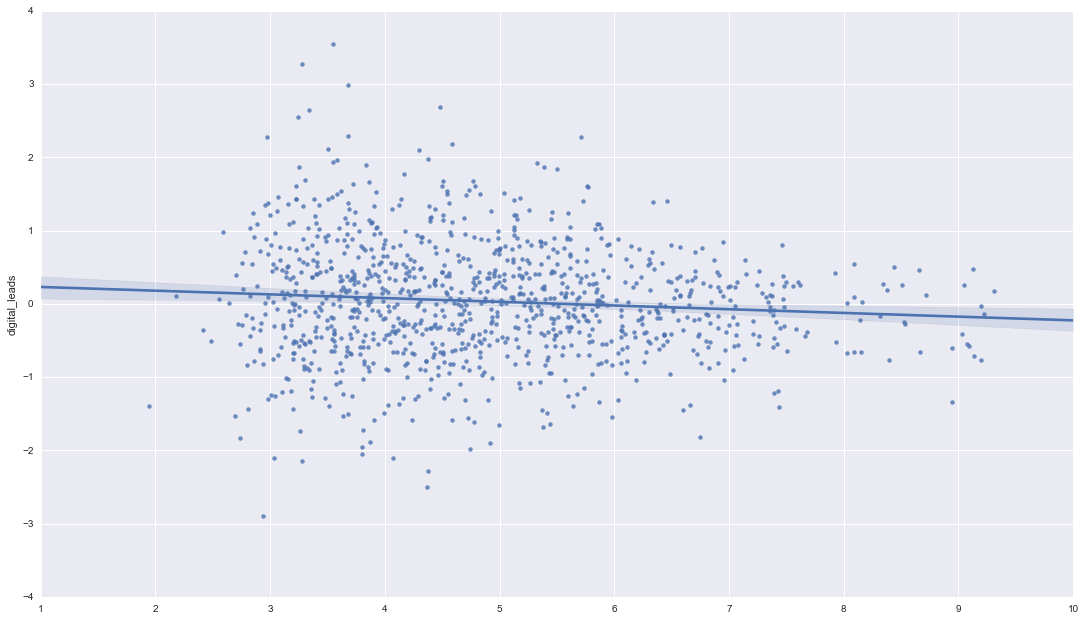

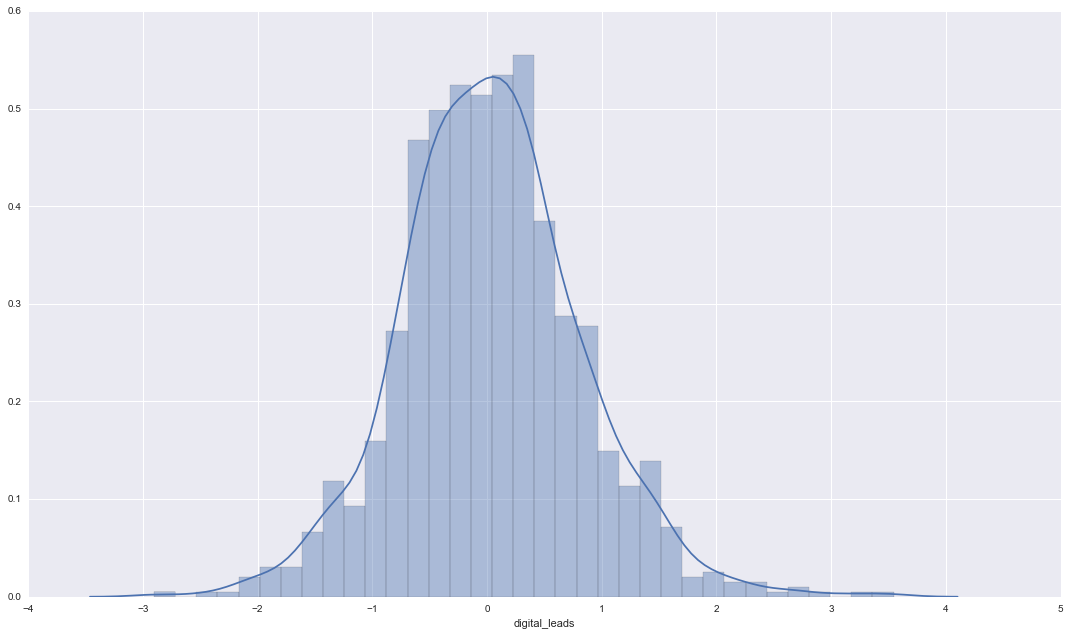

In [61]:
print param_list
xgb1 = XGBRegressor(**param_list)
modelfit(xgb1, train_cities_raw, test_cities_raw, predictors, log_transform=True)


In [66]:
#try 3 different max_depths, and 3 different child weights
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = tune_w_GS(param_test1, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')

# gsearch1 = GridSearchCV(estimator =XGBRegressor(**param_list), param_grid = param_test1, n_jobs=5,iid=False, 
#                         cv= KFold(cities_raw.shape[0], n_folds= 7, random_state = 27))

# gsearch1.fit(cities_raw[predictors],np.log(cities_raw[target]))
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

{'max_depth': 5, 'min_child_weight': 5}
-0.776695443104


([mean: -0.78511, std: 0.02197, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.78401, std: 0.02131, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.78445, std: 0.02049, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.77911, std: 0.02097, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.77700, std: 0.02083, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.77670, std: 0.02035, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.78624, std: 0.02087, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.78245, std: 0.01963, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.78220, std: 0.02079, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.78922, std: 0.02369, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -0.78717, std: 0.02384, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.78420, std: 0.02523, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_chil

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 678


Stopped at round  679

Model Report
Accuracy : 0.7835
R2 Score (Train): 0.956045
R2 Score (Test): 0.776016
residual mean:  0.0332316774082
residual standard error:  0.783147436477
Mean Prediction:  4.86576
Median Prediction:  4.66934


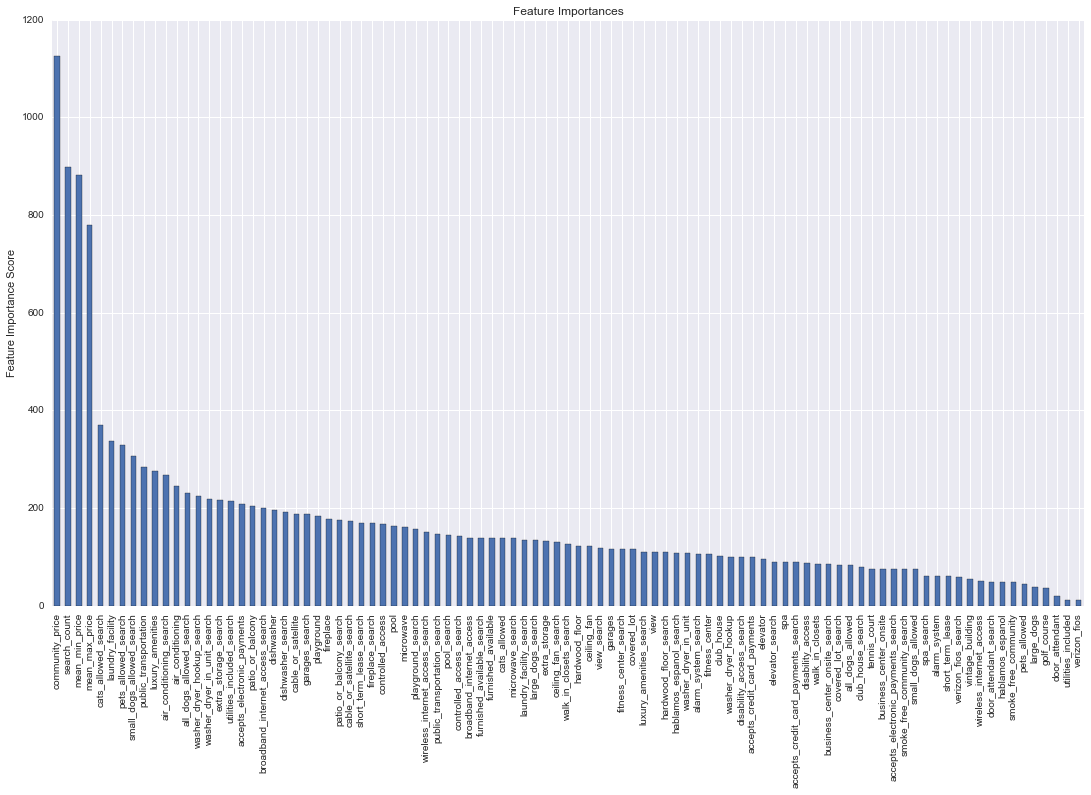

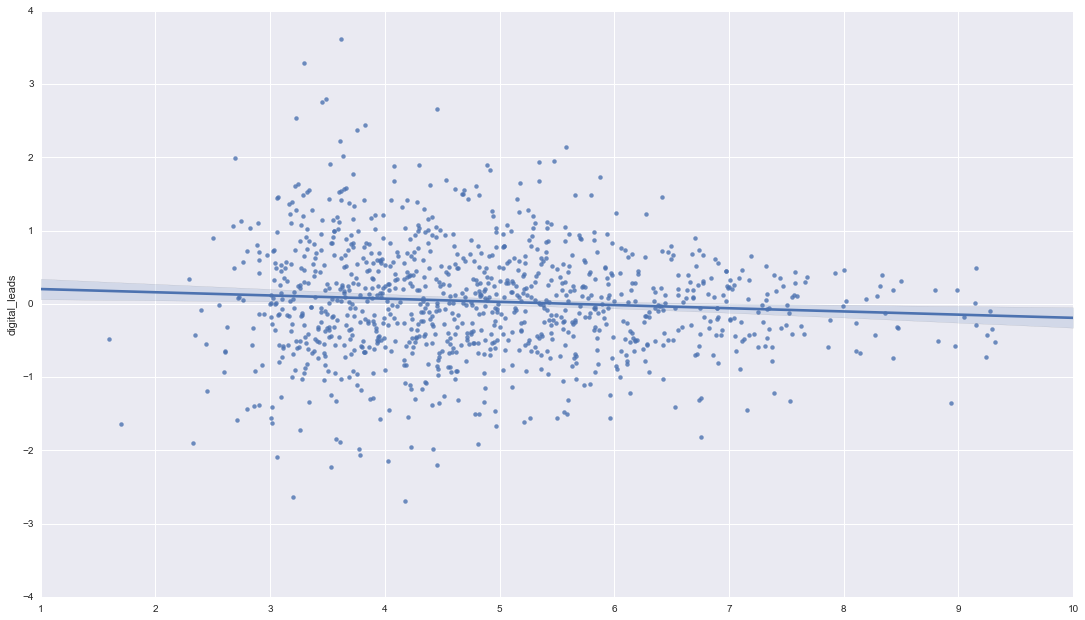

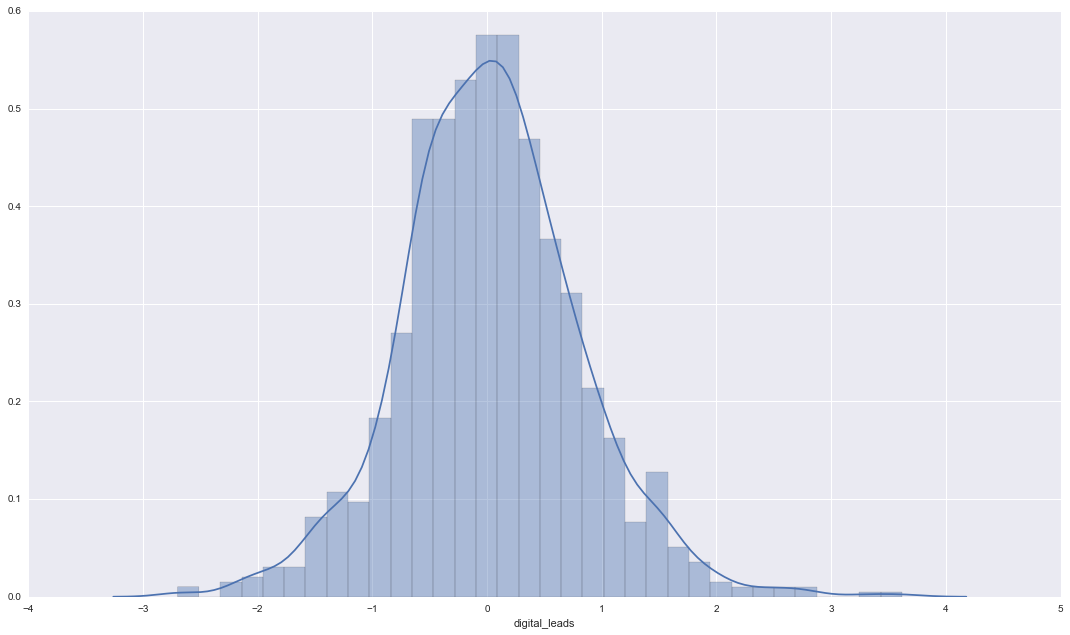

In [68]:
param_list['min_child_weight'] = 5
xgb7 = XGBRegressor(**param_list)
modelfit(xgb7, train_cities_raw, test_cities_raw, predictors)

In [73]:
param_test8 = {
    'learning_rate':[.005, .01, .015, .02],
    'n_estimators': [750,1000,1250],
    'max_depth':[4,5,6]
}

gsearch8 = tune_w_GS(param_test8, estimator = XGBRegressor(**param_list), data = cities_raw, predictors = predictors, 
                 target = 'digital_leads')

#gsearch7c.fit(cities_raw[groups],cities_raw[target])
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

{'n_estimators': 1250, 'learning_rate': 0.01, 'max_depth': 6}
-0.776181237945


([mean: -0.81540, std: 0.02526, params: {'n_estimators': 750, 'learning_rate': 0.005, 'max_depth': 4},
  mean: -0.79563, std: 0.02185, params: {'n_estimators': 1000, 'learning_rate': 0.005, 'max_depth': 4},
  mean: -0.78869, std: 0.02016, params: {'n_estimators': 1250, 'learning_rate': 0.005, 'max_depth': 4},
  mean: -0.80456, std: 0.02412, params: {'n_estimators': 750, 'learning_rate': 0.005, 'max_depth': 5},
  mean: -0.78748, std: 0.02069, params: {'n_estimators': 1000, 'learning_rate': 0.005, 'max_depth': 5},
  mean: -0.78218, std: 0.01906, params: {'n_estimators': 1250, 'learning_rate': 0.005, 'max_depth': 5},
  mean: -0.79993, std: 0.02477, params: {'n_estimators': 750, 'learning_rate': 0.005, 'max_depth': 6},
  mean: -0.78421, std: 0.02135, params: {'n_estimators': 1000, 'learning_rate': 0.005, 'max_depth': 6},
  mean: -0.78011, std: 0.02015, params: {'n_estimators': 1250, 'learning_rate': 0.005, 'max_depth': 6},
  mean: -0.78561, std: 0.01883, params: {'n_estimators': 750, 'lear

In [79]:
param_list = gsearch8.best_estimator_.get_params()

## This is our best model

I noodled around a bit with the order in which we find the parameters, mostly because there seems to be some relationship between them, and training them independently affects there values.

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 1124


Stopped at round  1125

Model Report
Accuracy : 0.7832
R2 Score (Train): 0.973088
R2 Score (Test): 0.776170
residual mean:  0.0329548243782
residual standard error:  0.782888292921
Mean Prediction:  4.86548
Median Prediction:  4.64499


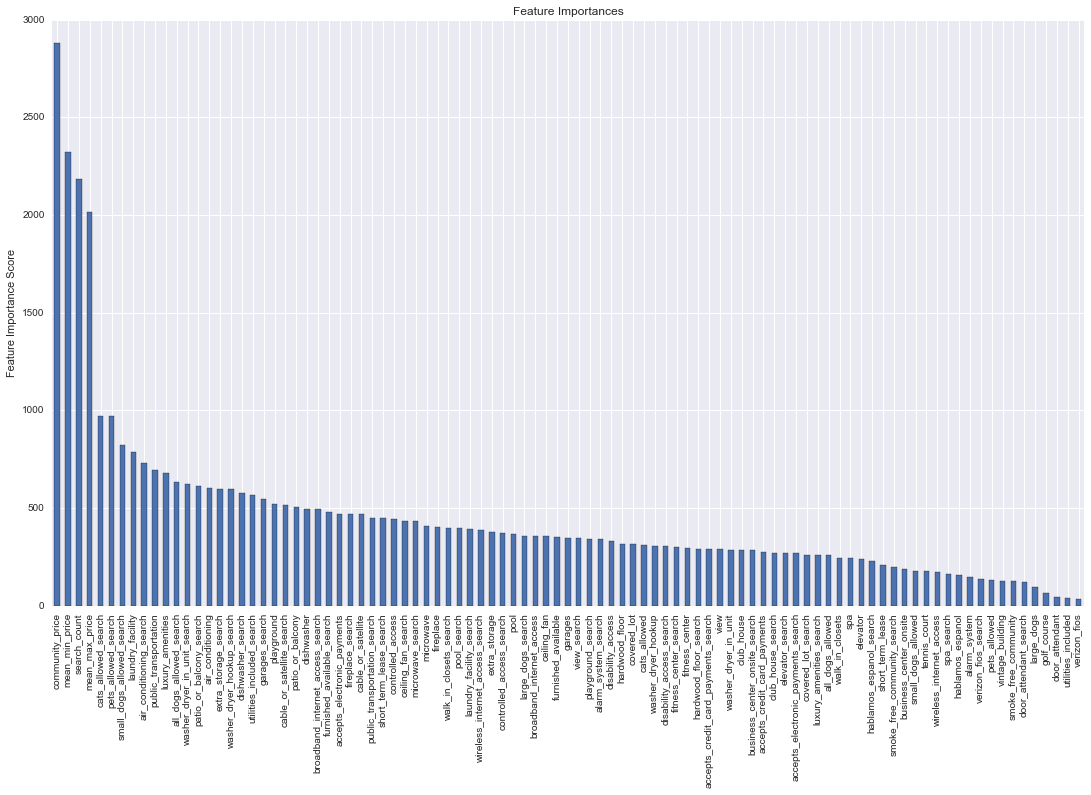

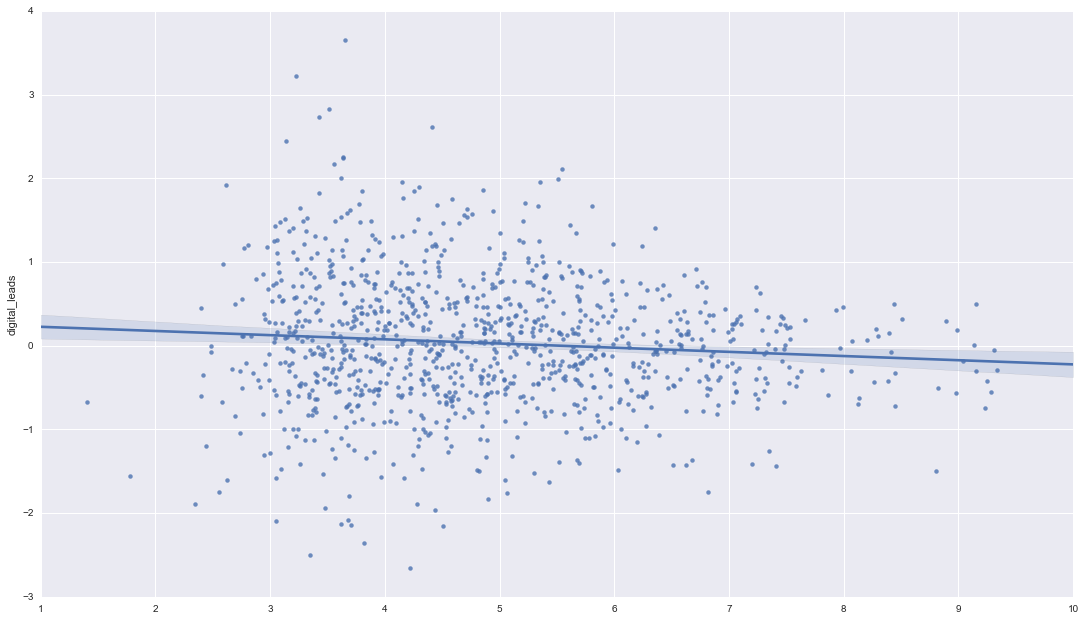

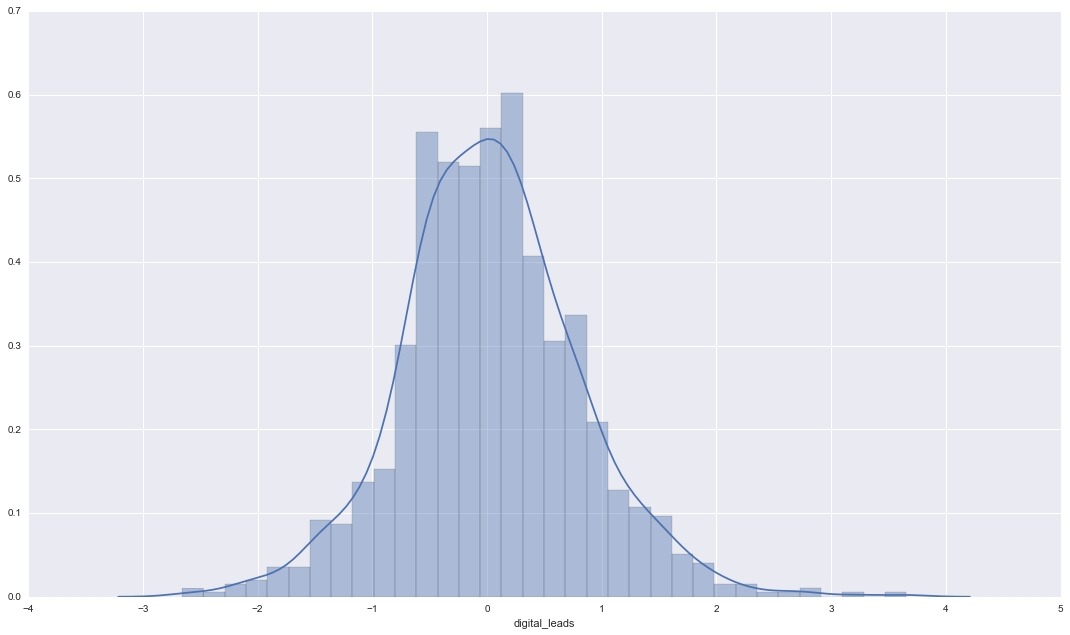

In [80]:
xgb8 = XGBRegressor(**param_list)
modelfit(xgb8, train_cities_raw, test_cities_raw, predictors)

In [ ]:
#Writes tuned model to a json file
with open('models/' + model_name + '.json', 'w') as f:
    json.dump(param_list, f)
